# Alzheimer Detection

In [10]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import itertools
import torch
from efficientnet_pytorch import EfficientNet

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preprocess Data

In [11]:
# Define the directory where the data is stored
# Replace with the path to your dataset
data_dir = '/Users/mrinoybanerjee/Desktop/Duke/Misc/Alzheimer_Detection/data/Dataset'

# Define transforms for the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.Randomgrayscale(p=0.1),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset with ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)

#with wandb.init(project='wound-detection'):
# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))  # 80% of dataset
val_size = len(dataset) - train_size  # 20% of dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

## Mean model: CNN

## Defining CNN architecture

In [15]:
# # Load a pre-trained model (e.g., ResNet18) and modify it for our task
model = models.resnet50(pretrained=True)

# Freeze all the layers in the pretrained model
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer with a new one that matches our number of classes (4 classes in our case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 

# Move the model to the GPU if available
model = model.to(device)

## Specify loss function and optimizer

In [16]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, only optimizing the parameters of the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

## Train the model

In [17]:
# Number of epochs to train for
num_epochs = 3

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        # Move the input and label tensors to the correct device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print statistics
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")
    
    # Validation loss
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Loss: {val_loss / len(valloader)}, Accuracy: {100 * correct / total}%')

# Save the model
torch.save(model.state_dict(), '/Users/mrinoybanerjee/Desktop/Duke/Misc/Alzheimer_Detection/Models/alzheimer_cnn_model.pth')


Epoch 1, Loss: 0.9874262813478708
Validation Loss: 0.9305250898003579, Accuracy: 55.0%
Epoch 2, Loss: 0.939947634190321
Validation Loss: 0.901094937324524, Accuracy: 57.34375%
Epoch 3, Loss: 0.91855812035501
Validation Loss: 0.9114125564694404, Accuracy: 56.328125%


## EfficientNet for improved performance

In [29]:
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)

# Move the model to the GPU if available
efficientnet_model = efficientnet_model.to(device)

Loaded pretrained weights for efficientnet-b0


## Specify optimizer

In [30]:
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)

## Train model

In [ ]:
# Number of epochs to train for
num_epochs = 10

# train efficientnet model
for epoch in range(num_epochs):
    efficientnet_model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # torch.uint8 is supported on the CPU only, so we need to move the input and label tensors to the correct device
    for inputs, labels in trainloader:
        # Move the input and label tensors to the correct device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print statistics
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")
    
    # Validation loss
    efficientnet_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = efficientnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Loss: {val_loss / len(valloader)}, Accuracy: {100 * correct / total}%')

# Save the model
    
torch.save(efficientnet_model.state_dict(), '/Users/mrinoybanerjee/Desktop/Duke/Misc/Alzheimer_Detection/Models/alzheimer_efficientnet_model.pth')


## Vision Transformer for improved performance

In [33]:
%pip install timm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 926.2 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
# Load a pre-trained Vision Transformer model
vit_model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

# Move the model to the GPU if available
vit_model = vit_model.to(device)


Using cache found in /Users/mrinoybanerjee/.cache/torch/hub/facebookresearch_deit_main
/Users/mrinoybanerjee/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/Users/mrinoybanerjee/.cache/torch/hub/facebookresearch_deit_main/models.py:78: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_small_patch16_224(pretrained=False, **kwargs):
/Users/mrinoybanerjee/.cache/torch/hub/facebookresearch_deit_main/models.py:93: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered confli

## Define loss function and optimizer

In [35]:
# Define the optimizer, only optimizing the parameters of the final layer
optimizer = optim.Adam(vit_model.parameters(), lr=0.001)

## Train Model

In [ ]:
# Number of epochs to train for
num_epochs = 10

# train Vision Transformer model
for epoch in range(num_epochs):
    vit_model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # torch.uint8 is supported on the CPU only, so we need to move the input and label tensors to the correct device
    for inputs, labels in trainloader:
        # Move the input and label tensors to the correct device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print statistics
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")
    
    # Validation loss
    vit_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vit_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Loss: {val_loss / len(valloader)}, Accuracy: {100 * correct / total}%')

## Model Evaluation

In [20]:
def plot_loss(train_losses, val_losses, title='Loss Plot'):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [23]:
def evaluate_model(model, dataloader, device, criterion):
    model.eval()  # Set model to evaluate mode
    val_losses = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    # Plot loss and confusion matrix
    plot_loss([], val_losses, title='Validation Loss')  # Pass training losses if available
    plot_confusion_matrix(cm, classes=['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented'], title='Confusion Matrix')
    
    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


/Users/mrinoybanerjee/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


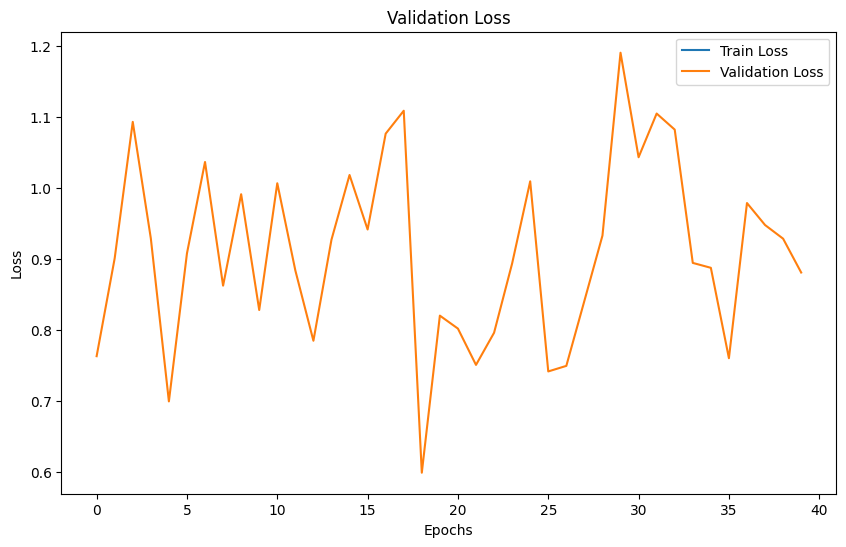

Confusion matrix, without normalization
[[ 11   0  89  71]
 [  0   0   8   7]
 [  4   0 552  85]
 [  5   0 297 151]]
Accuracy: 0.5578
Precision: 0.5359
Recall: 0.5578
F1 Score: 0.5031


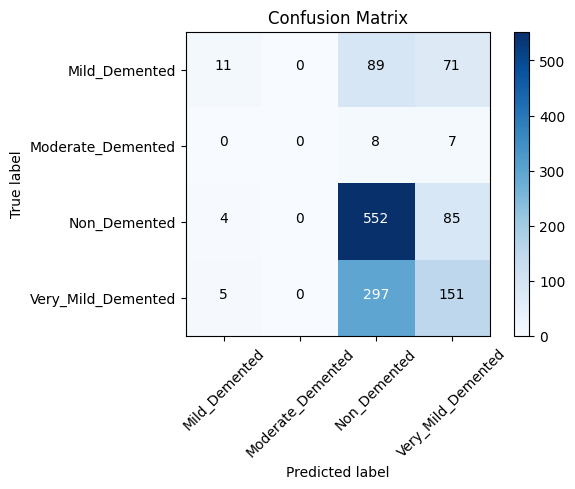

In [24]:
# Evaluating ResNet
evaluate_model(model, valloader, device, criterion)

# Evaluating Vision Transformer
evaluate_model(vit_model, valloader, device, criterion)
